# **Evaluating the Effectiveness of a New Web Page Design in Improving Conversion Rates**

---

## 1. Project Overview

* **Business Context:**

A company has developed a new web page design with the aim of increasing the number of users who convert (i.e., pay for the company's product). This is a crucial business objective as conversion rates directly impact revenue and overall business performance.

* **Objective:**

To conduct an A/B test to determine whether the new web page design significantly improves conversion rates compared to the existing design. This involves comparing the performance of the two designs in terms of the proportion of users who make a purchase.

* **Expected Outcomes:**
1. Identify whether the new web page design has a statistically significant impact on conversion rates.
2. Provide recommendations based on the test results to guide decision-making regarding the implementation of the new design.

* **Data Source:**

The dataset was obtained from Kaggle.com (E-commerce A/B testing | [https://www.kaggle.com/datasets/ahmedmohameddawoud/ecommerce-ab-testing/data]). It contains data on user behavior and conversion rates for both the old and new web page designs. This dataset allows for a comprehensive analysis of the impact of the design change on user behavior.

* **Methodology:**

1. Data Cleaning and Preprocessing: Clean and prepare the dataset for analysis. This ensures data quality and reliability for accurate results.
2. A/B Testing: Conduct an A/B test to compare the conversion rates between the old and new web page designs. This involves randomly assigning users to either the control group (old page) or the treatment group (new page).
3. Statistical Analysis: Perform statistical tests (e.g., z-test for proportions) to determine the significance of the observed differences in conversion rates. This provides a quantitative measure of the impact of the design change.
4. Actionable Recommendations: Providing data-driven recommendations to the company based on the analysis results.

The findings of this project will help the company make an informed decision regarding whether to implement the new web page design or retain the existing one. By providing evidence-based insights, this analysis will contribute to optimizing the company's website for improved conversion rates and business performance.

---

## 2. Data Wrangling

### 2.1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

pd.set_option("display.max_columns",None)
pd.set_option("display.float_format", "{:.4f}".format)

### 2.2. Load Dataset

In [ ]:
data = pd.read_csv('/content/new_design_page_test.csv')
data.columns = ['user_id', 'time', 'group', 'landing_page', 'converted']
data.user_id = data.user_id.astype(str)
data

,user_id,time,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294473,751197,28:38.6,control,old_page,0
294474,945152,51:57.1,control,old_page,0
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0


### 2.3. Data Overview

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  object
 1   time          294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 11.2+ MB


This dataset describes of an A/B test results run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who `convert`, meaning the number of users who decide to pay for the company's product.

It consists of 5 features and more than 290.000 rows:

* `user_id`: Contains user ID
* `time`: Time of a session
* `group`: Contains 2 variables, `control` and `treatment`
* `landing_page`: What version of a site a user saw, `old_page` or `new_page`
* `converted`: If a user made a purchase (1) or not (0)

### 2.4. Data Inspection

#### 2.4.1. Missing Values

<Axes: >

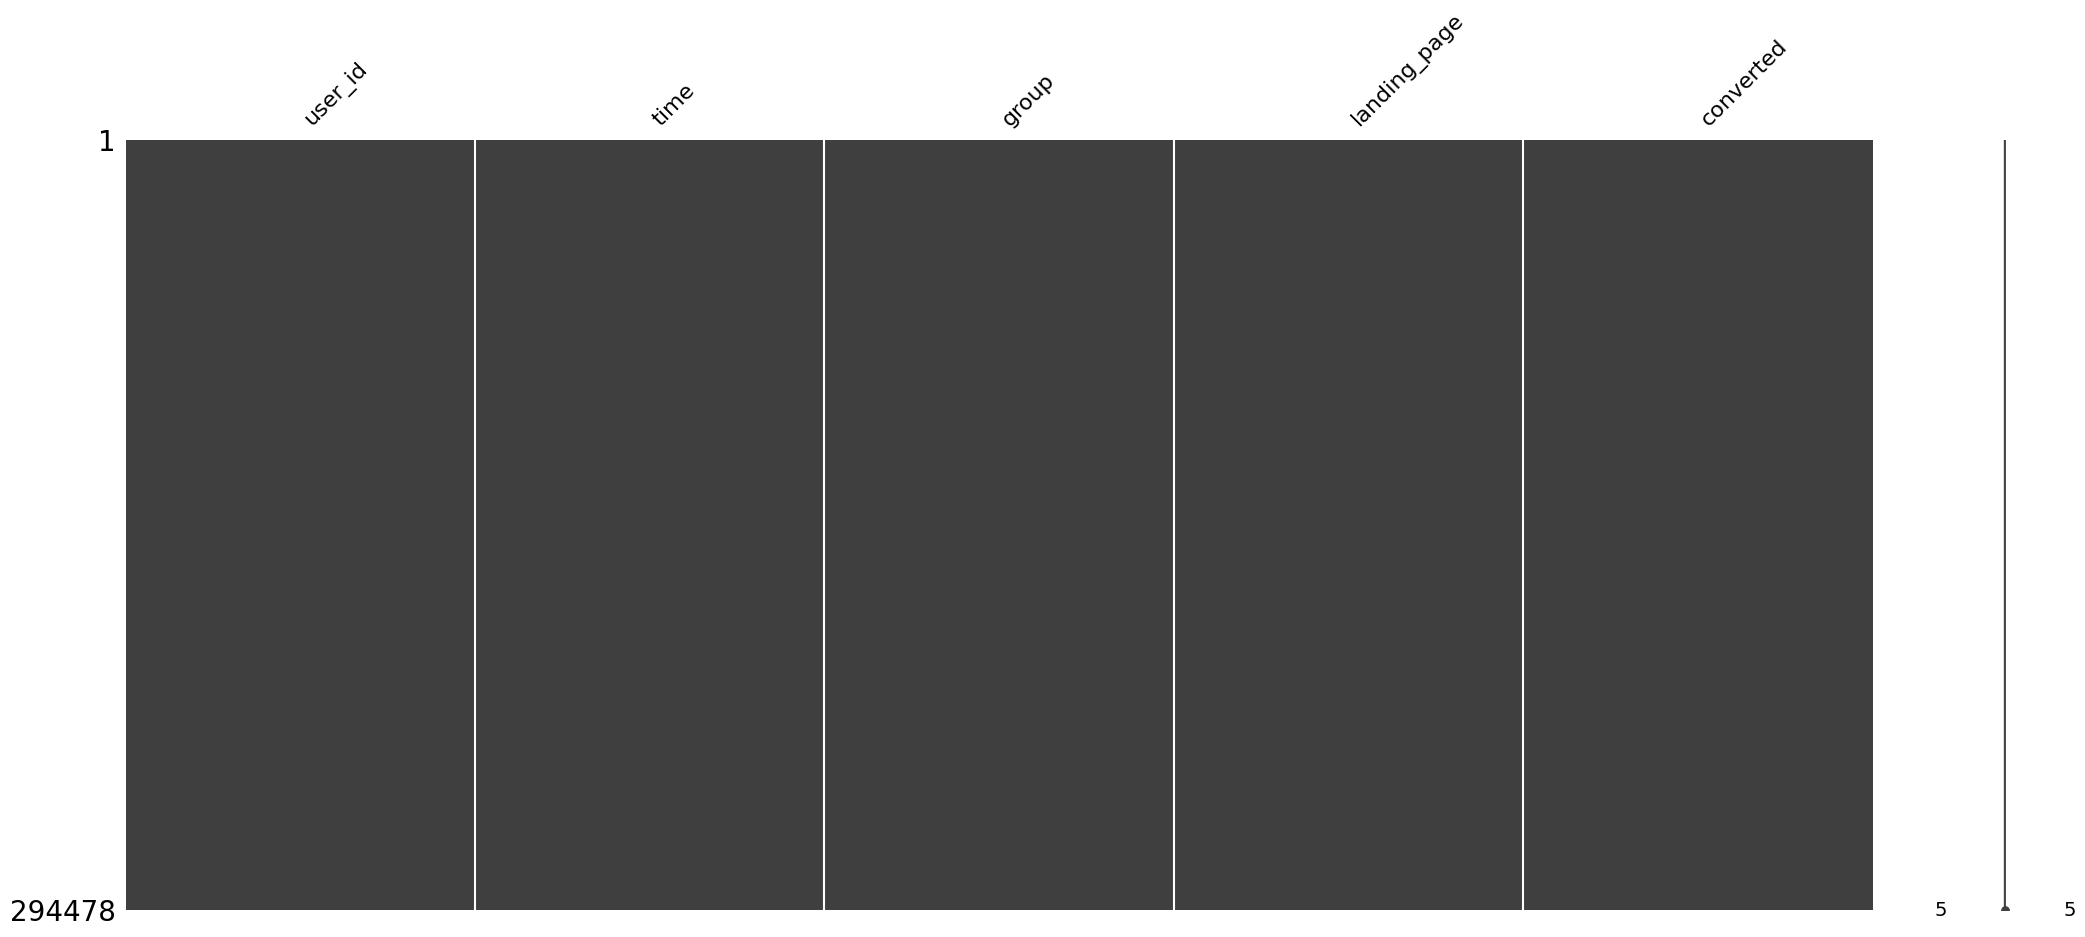

In [ ]:
msno.matrix(data)

There are no missing values!

#### 2.4.2. Mismatch Data

The correct data are on the feature group, `control` should have `old_page` then`treatment` should have `new_page`.

In [ ]:
mismatch_group = data[((data['group']=='treatment') & (data['landing_page']=='old_page') | (data['group']=='control') & (data['landing_page']=='new_page'))]
mismatch_group

,user_id,time,group,landing_page,converted
22,767017,58:15.0,control,new_page,0
240,733976,11:16.4,control,new_page,0
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
...,...,...,...,...,...
294014,813406,25:33.2,treatment,old_page,0
294200,928506,32:10.5,control,new_page,0
294252,892498,11:10.5,treatment,old_page,0
294253,886135,49:20.5,control,new_page,0


In [ ]:
mismatch_tab = pd.crosstab(index=data['group'], columns=data['landing_page'], normalize='columns') * 100
mismatch_tab

landing_page,new_page,old_page
group,,
control,1.3094,98.6654
treatment,98.6906,1.3346


In [ ]:
mismatch_tab_melted = mismatch_tab.reset_index().melt(id_vars='group', var_name='landing_page', value_name='percentage')

fig = px.bar(
    mismatch_tab_melted,
    x='group',
    y='percentage',
    color='landing_page',
    title='Mismatch Data | Group != Landing Page',
    labels={'percentage': 'Mismatch Data', 'group': 'Group', 'landing_page': 'Landing Page'},
    barmode='group',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    text=mismatch_tab_melted['percentage'].apply(lambda x: f'{x:.2f}%')
)
fig.update_traces(textposition='outside')
fig.update_layout(
    yaxis_title='Percentage',
    xaxis_title='Group',
    legend_title='Landing Page',
    showlegend=True,
    width=800,
    height=600
)
fig.show()

Since these mismatch data had a small count, 3893 out of 294478 (only `1% - 2%`), I'll drop these rows.

In [ ]:
data = data[~((data['group']=='treatment') & (data['landing_page']=='old_page') | (data['group']=='control') & (data['landing_page']=='new_page'))]
data.shape

(290585, 5)

#### 2.4.3. Duplicate

In [ ]:
data[data.duplicated(subset = ['user_id']) == True]

,user_id,time,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0


In [ ]:
data[data['user_id'] == '773192']

,user_id,time,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


In [ ]:
data = data.drop_duplicates('user_id')
len(data[data.duplicated(subset = ['user_id']) == True])

0

In [ ]:
data.shape

(290584, 5)

The dataset is clean now!

## 3. Hypothesis Testing

### 3.1. Power Analysis

I'll conduct a power analysis to see the minimum number of data that are needed to prove/reject the hypothesis.

In [ ]:
control_convertrate = data[data['group'] == 'control']['converted'].mean() * 100

print(f'Control Group Conversion Rate: {str(round(control_convertrate,2))} %')

Control Group Conversion Rate: 12.04 %


The conversion rate (number of purchases/number of visits) in the company before was `12.04 %` and the increase expected will be set to `14 %` to ensure that a new design page of the site will certainly increase the conversion.

In [ ]:
effect_size = sms.proportion_effectsize(0.12, 0.14)

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1)

required_n = ceil(required_n)

print(f'For this experiment, we need at least {required_n} data for each group')

For this experiment, we need at least 4433 data for each group


In [ ]:
data['group'].value_counts()

,count
group,
treatment,145310
control,145274


The data fulfilled the requirement for doing the experiment since both groups had more than 145.000 data.

In [ ]:
conversion_rates = data.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)
se_p = lambda x: stats.sem(x, ddof=1)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])*100
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.reset_index(inplace=True)
conversion_rates

,group,conversion_rate,std_deviation,std_error
0,control,12.0386,32.5414,0.0854
1,treatment,11.8808,32.3564,0.0849


In [ ]:
fig = px.bar(
    conversion_rates,
    x='group',
    y='conversion_rate',
    color='group',
    title='Conversion Rate',
    labels={'conversion_rate': 'Conversion Rate', 'group': 'Group'},
    color_discrete_sequence=px.colors.qualitative.Pastel,
    text=conversion_rates['conversion_rate'].apply(lambda x: f'{x:.2f}%')
)

fig.update_traces(textposition='outside')

fig.update_layout(
    yaxis_title='Percentage',
    xaxis_title='Group',
    legend_title='Conversion Rate',
    showlegend=False,
    width=800,
    height=600
)
fig.show()

It shows that the new design page performs poor than the old page. The change in conversion rate does not suggest that there is an improvement when we use the new page (`11.9 %`), it is slightly lower than the old page (`12 %`).

However, let's validate whether this difference is statistically significant!

### 3.2. The A/B Test

**Does this new design page improve the conversion rates?**

* `H0`: The new design page `does not significantly improve the conversion rates`.
* `H1`: The new design page `does significantly improve the conversion rates`.

I'll perform a statistical test to compare these two groups with using z-test to calculate the p-value considering the large sample size.

Let's reveal the p-value and confidence interval!

In [ ]:
control_results = data[data['group'] == 'control']['converted']
treatment_results = data[data['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z Statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% Confidence Interval for Control Group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence Interval for Treatment Group: [{lower_treat:.3f}, {upper_treat:.3f}]')

if pval < 0.05:
    print('Reject the null hypothesis')
else:
    print('''
    ---------------------------------------------------------------------------------------------------
    Fail to reject the null hypothesis \n

    It statistically validates that the new design page does not significantly improve the conversion rates.
    ---------------------------------------------------------------------------------------------------
    ''')

Z Statistic: 1.31
p-value: 0.190
95% Confidence Interval for Control Group: [0.119, 0.122]
95% Confidence Interval for Treatment Group: [0.117, 0.120]

    ---------------------------------------------------------------------------------------------------
    Fail to reject the null hypothesis 


    It statistically validates that the new design page does not significantly improve the conversion rates.
    ---------------------------------------------------------------------------------------------------
    


## 4. Conclusion

The A/B test results indicate that there is no statistically significant evidence to support the claim that the new design page improves conversion rates. With a `Z statistic of 1.31` and a `p-value of 0.190`, **which is greater than the significance level of 0.05**, `we fail to reject the null hypothesis`.


* **P-value:** A p-value of 0.190 suggests that there is a 19% chance of observing the obtained results (or more extreme results) if there is truly no difference in conversion rates between the old and new design pages. This probability is higher than the commonly used significance level of 0.05, leading to the failure to reject the null hypothesis.
* **Confidence Intervals:** The 95% confidence intervals for the conversion rates of both the control group (old page) and the treatment group (new page) overlap. This overlap further supports the conclusion that there is no significant difference between the two designs.
* **Conversion Rates:** The observed conversion rates for the control group (`12.04%`) and the treatment group (`11.88%`) are very similar. The slight difference is not statistically significant, as indicated by the p-value and confidence intervals.

**Recommendation**

Based on these findings, it is recommended to **retain the existing design page or explore alternative design modifications for further testing**. The current new design page does not demonstrate a statistically significant improvement in conversion rates, and therefore, implementing it might not yield the desired positive impact on business outcomes.